In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd

In [2]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Metric

import joblib

2024-04-27 13:06:18.839343: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-27 13:06:19.032919: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-27 13:06:19.032947: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-27 13:06:19.065882: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-27 13:06:19.822742: W tensorflow/stream_executor/platform/de

In [3]:
def re_dataset(dataset):
    #print(dataset.head())
    tcp_flag = dataset['TCP Flag'].values
    tcp_U = []
    tcp_A = []
    tcp_P = []
    tcp_R = []
    tcp_S = []
    tcp_F = []

    #UAPRSF
    for flag in tcp_flag:
        ll = 0
        for tcp in [tcp_U,tcp_A,tcp_P,tcp_R,tcp_S,tcp_F]:
            #print(flag[ll])
            if flag[ll] == '-':
                tcp.append(0)
            else:
                tcp.append(1)
            ll += 1
    dataset.insert(7, column="tcp_U", value=tcp_U)
    dataset.insert(8, column="tcp_A", value=tcp_A)
    dataset.insert(9, column="tcp_P", value=tcp_P)
    dataset.insert(10, column="tcp_R", value=tcp_R)
    dataset.insert(11, column="tcp_S", value=tcp_S)
    dataset.insert(12, column="tcp_F", value=tcp_F)
    dataset.drop(columns=['TCP Flag'], inplace=True, axis=1)
    return dataset

In [4]:
def train_data_func(filename):
    # First, we get the data
    dataset = pd.read_csv(filename, index_col='資料時間', parse_dates=['資料時間'])
    dataset = dataset.drop(['來源名稱解析','來源區域','來源Port解析','目的名稱解析','目的區域','目的Port解析','流入介面','流出介面','設備'], axis=1)
    dataset = re_dataset(dataset)
    print("hacker 0:", len(dataset[dataset["hacker"]==0]), "hacker 1:", len(dataset[dataset["hacker"]==1]), "hacker 2:", len(dataset[dataset["hacker"]==2]))
    text_set = dataset[['來源IP','Protocol','目的IP']]
    num_set = dataset[['Session','Packets','Bytes','tcp_U','tcp_A','tcp_P','tcp_R','tcp_S','tcp_F','dstip_count','dstport_count']]#'來源Port','目的Port',

    xx_text = text_set.iloc[:,:].to_numpy()
    xx_num = num_set.iloc[:,:].to_numpy()
    yy = dataset.iloc[:,-1].to_numpy()

    # 將數字特徵進行標準化
    #scaler = StandardScaler()
    scaler = MinMaxScaler()
    numeric_data_scaled = scaler.fit_transform(xx_num)
    # 保存標準化參數
    joblib.dump(scaler, 'scaler.pkl')

    # 將標籤轉換為 one-hot 編碼
    yy = to_categorical(yy, 3)

    # 將文字特徵進行 One-Hot 編碼
    encoder = OneHotEncoder( categories='auto')#sparse_output=False,
    text_data_encoded = encoder.fit_transform(xx_text.reshape(-1, 1))#
    print(numeric_data_scaled.shape, text_data_encoded.shape)

    X = np.array(list(zip(numeric_data_scaled, text_data_encoded)), dtype="object")
    # 分割數據集為訓練集和測試集
    X_train, X_test, y_train, y_test = train_test_split(
        X, yy, test_size=0.2, random_state=42
    )
    print('訓練集:',X_train.shape, '測試集:', X_test.shape)
    # 分割文字與數字資料集
    X_train_numeric, X_train_text = X_train[:, 0], X_train[:, 1]
    X_test_numeric, X_test_text = X_test[:, 0], X_test[:, 1]

    X_train_numeric = np.array([np.array(val) for val in X_train_numeric])
    X_train_text = np.array([np.array(val) for val in X_train_text])
    y_train = np.array([np.array(val) for val in y_train])
    X_test_numeric = np.array([np.array(val) for val in X_test_numeric])
    X_test_text = np.array([np.array(val) for val in X_test_text])
    y_test = np.array([np.array(val) for val in y_test])
    print(X_train_numeric.shape, X_train_text.shape, y_train.shape, X_test_numeric.shape, X_test_text.shape, y_test.shape)
    
    model = build_model(X_train_numeric)
    print(model.summary())

    early_stopping = set_early_stop()
    # 將數字特徵和文字特徵分別傳遞給模型進行訓練
    history = model.fit(X_train_numeric, y_train, epochs=5, batch_size=32, validation_data=(X_test_numeric, y_test), callbacks=[early_stopping])
    print(model.evaluate(X_train_numeric, y_train))
    loss, accuracy, recall, recall_n = model.evaluate(X_train_numeric, y_train)
    print(f"Loss: {loss}, Accuracy: {accuracy}, Recall: {recall}")#, F1 Score: {f1_score}
    
    model.save('NN2-cp1.keras')  # 保存模型到 HDF5 文件
    plot_acc(history)
    plot_val_loss(history)

In [5]:
class F1Score(Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

In [6]:
def build_model(X_train_numeric):
    # 分別創建數字特徵和文字特徵的輸入層
    numeric_input = Input(shape=(X_train_numeric.shape[1],), name='numeric_input')
    # 分別處理數字特徵和文字特徵的層
    numeric_output = Dense(units=100, activation='relu')(numeric_input)
    #sigmoid,relu,softmax,gelu,LeakyReLU
    # 在合併後的結果上添加更多層
    final_output = Dense(units=80, activation='relu', kernel_regularizer=l2(0.001))(numeric_output)
    final_output = BatchNormalization()(final_output)
    final_output = Dropout(0.2)(final_output)
    final_output = Dense(units=60, activation='relu', kernel_regularizer=l2(0.001))(final_output)
    final_output = BatchNormalization()(final_output)
    final_output = Dropout(0.2)(final_output)
    final_output = Dense(units=30, activation='relu', kernel_regularizer=l2(0.001))(final_output)
    final_output = BatchNormalization()(final_output)
    final_output = Dense(units=3, activation='softmax')(final_output)
    
    
    # 創建模型
    model = Model(inputs=numeric_input, outputs=final_output)#[numeric_input, text_input]
    
    # 編譯模型（使用適當的損失函數和優化器）
    #optimizer:adam,sgd
    #loss:binary_crossentropy,categorical_crossentropy,mean_squared_error
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error', metrics=['accuracy', tf.keras.metrics.AUC(name='auc'), tf.keras.metrics.Recall()])#, F1Score()
    return model

In [7]:
def set_early_stop():
    # 设置早停
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='accuracy',    # 监控验证损失 val_loss
        patience=5,           # 没有改善的训练周期数
        restore_best_weights=True  # 恢复到最佳模型权重
    )
    return early_stopping

In [8]:
def plot_acc(history):
    # 繪製訓練和驗證準確率
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

In [9]:
def plot_val_loss(history):
    # 繪製訓練和驗證損失
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

In [10]:
def polt_ROC(y_test,pred_probs):
    # 預測
    #pred_probs = model.predict(X_test).ravel()
    
    # 計算 ROC 曲線和 AUC
    #fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
    #roc_auc = auc(fpr, tpr)
    
    # 计算每个类别的ROC曲线和AUC
    for i in range(len(pred_probs)):
        fpr, tpr, _ = roc_curve(y_test[:, i], pred_probs[:, i])
        roc_auc = auc(fpr, tpr)

        plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc}) for class {i}')
    
    
    
    # 繪製 ROC 曲線
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Multi-Class')
    plt.legend(loc="lower right")
    plt.show()
    

In [11]:
def plot_acc(history):
    # Set the style
    plt.style.use('seaborn-darkgrid')  # Using a dark grid seaborn style for a refined look

    # Draw the plots
    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='slateblue', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='salmon', linewidth=2, alpha=0.8)

    # Set the title and labels
    plt.title('Training and Validation Accuracy', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('Accuracy', fontsize=14, fontweight='bold')

    # Customize the legend
    plt.legend(fontsize=12, loc='lower right')

    # Show grid lines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')
    
    # Show the plot
    plt.tight_layout()
    plt.show()

In [12]:
def plot_val_loss(history):
    # Set the style
    plt.style.use('seaborn-darkgrid')  # Refined look with dark grid

    plt.figure(figsize=(12, 4))
    # Draw the plots for loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss', color='mediumseagreen', linewidth=2, alpha=0.8)
    plt.plot(history.history['val_loss'], label='Validation Loss', color='tomato', linewidth=2, alpha=0.8)

    # Set the title and labels with bold fonts
    plt.title('Training and Validation Loss', fontsize=16, fontweight='bold')
    plt.xlabel('Epoch', fontsize=14, fontweight='bold')
    plt.ylabel('Loss', fontsize=14, fontweight='bold')

    # Customize the legend
    plt.legend(fontsize=12, loc='upper right')

    # Show grid lines
    plt.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray')

    # Show the plot
    plt.tight_layout()
    plt.show()


## load new test data

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import load_model

In [14]:
def vail_data(filename):
    dataset_test = pd.read_csv(filename, index_col='資料時間', parse_dates=['資料時間'])
    dataset_test = dataset_test.drop(['來源名稱解析','來源區域','來源Port解析','目的名稱解析','目的區域','目的Port解析','流入介面','流出介面','設備'], axis=1)
    dataset_test = re_dataset(dataset_test)
    print("hacker 0:", len(dataset_test[dataset_test["hacker"]==0]), ", hacker 1:", len(dataset_test[dataset_test["hacker"]==1]), ", hacker 2:", len(dataset_test[dataset_test["hacker"]==2]))
    text_set = dataset_test[['來源IP','Protocol','目的IP']]
    num_set = dataset_test[['Session','Packets','Bytes','tcp_U','tcp_A','tcp_P','tcp_R','tcp_S','tcp_F','dstip_count','dstport_count']]#'來源Port','目的Port',
    test_xx_text = text_set.iloc[:,:].to_numpy()
    test_xx_num = num_set.iloc[:,:].to_numpy()
    test_yy = dataset_test.iloc[:,-1].to_numpy()
    test_xx_text.shape, test_xx_num.shape, test_yy.shape
    # 將數字特徵進行標準化
    #scaler = StandardScaler()
    # 載入標準化參數
    scaler = joblib.load('scaler.pkl')
    test_numeric_data_scaled = scaler.fit_transform(test_xx_num)
    # 將文字特徵進行 One-Hot 編碼
    #encoder = OneHotEncoder(sparse=False, categories='auto')
    #test_text_data_encoded = encoder.fit_transform(test_xx_text)#.reshape(-1, 1)
    x_new_test_numeric = np.array([np.array(val) for val in test_numeric_data_scaled])
    #x_new_test_text = np.array([np.array(val) for val in test_text_data_encoded])
    y_new_test = np.array([np.array(val) for val in test_yy])

    # 加载之前保存的模型
    model_test = load_model('NN2-cp1.keras')
    y_pre=model_test.predict(x_new_test_numeric, verbose=0)
    #print(y_pre)
    # 將預測轉換為二進制標籤
    #class_predictions = (y_pre > 0.5).astype(int)
    class_predictions = np.argmax(y_pre, axis=1)
    print(class_predictions[:5])

    # 計算並打印準確度
    accuracy = accuracy_score(y_new_test, class_predictions)
    print("準確度:", accuracy)
    
    # 打印混淆矩陣
    conf_matrix = confusion_matrix(y_new_test, class_predictions)
    print("混淆矩陣:")
    print(conf_matrix.shape)
    #print(conf_matrix)

    # 調用畫圖函數
    plot_confusion_matrix(conf_matrix, class_names=['hacker 0', 'hacker 1', 'hacker 2'])    
    # 顯示圖片
    plt.show()
    
    #畫出ROC AUC 限定二元分類
    #polt_ROC(y_new_test,class_predictions.ravel())

    # 計算錯誤預測
    errors = y_new_test != class_predictions
    # 篩選出錯誤預測的項目
    error_items = test_xx_num[errors]
    #for i in range(len(error_items)):
    #    print(f"Item: {error_items[i]}")
    #    print(f"Predicted: {class_predictions[errors][i]}, Actual: {y_new_test[errors][i]}")

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# 畫圖函數
def plot_confusion_matrix(cm, class_names):
    """
    畫出混淆矩陣
    :param cm: 混淆矩陣
    :param class_names: 類別名稱
    """
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    # 移除格線
    ax.grid(False)

    # 顯示所有的刻度。
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # 標記刻度標籤
           xticklabels=class_names, yticklabels=class_names,
           title='Confusion Matrix',
           ylabel='True label',
           xlabel='Predicted label')

    # 旋轉刻度標籤並設置對齊方式。
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # 循環遍歷混淆矩陣並在單元格中添加文本。
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > cm.max() / 2. else "black")
    fig.tight_layout()
    return ax




hacker 0: 38284 hacker 1: 21466 hacker 2: 19564
(79314, 11) (237942, 9120)
訓練集: (63451, 2) 測試集: (15863, 2)
(63451, 11) (63451,) (63451, 3) (15863, 11) (15863,) (15863, 3)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 numeric_input (InputLayer)  [(None, 11)]              0         
                                                                 
 dense (Dense)               (None, 100)               1200      
                                                                 
 dense_1 (Dense)             (None, 80)                8080      
                                                                 
 batch_normalization (BatchN  (None, 80)               320       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 80)                0         
                      

2024-04-27 13:06:28.364311: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-27 13:06:28.364384: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (centos7.husan.cc): /proc/driver/nvidia/version does not exist
2024-04-27 13:06:28.364824: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


None
Epoch 1/5
1983/1983 [==============================] - 8s 3ms/step - loss: 0.2421 - accuracy: 0.8460 - auc: 0.9448 - recall: 0.8217 - val_loss: 0.1776 - val_accuracy: 0.9086 - val_auc: 0.9855 - val_recall: 0.9068
Epoch 2/5
1983/1983 [==============================] - 6s 3ms/step - loss: 0.1603 - accuracy: 0.9198 - auc: 0.9775 - recall: 0.9143 - val_loss: 0.1268 - val_accuracy: 0.9392 - val_auc: 0.9939 - val_recall: 0.9377
Epoch 3/5
1983/1983 [==============================] - 6s 3ms/step - loss: 0.1200 - accuracy: 0.9371 - auc: 0.9841 - recall: 0.9339 - val_loss: 0.0991 - val_accuracy: 0.9484 - val_auc: 0.9932 - val_recall: 0.9479
Epoch 4/5
1983/1983 [==============================] - 6s 3ms/step - loss: 0.0949 - accuracy: 0.9453 - auc: 0.9866 - recall: 0.9432 - val_loss: 0.0800 - val_accuracy: 0.9617 - val_auc: 0.9939 - val_recall: 0.9613
Epoch 5/5
1983/1983 [==============================] - 3s 2ms/step - loss: 0.0667 - accuracy: 0.9625 - auc: 0.9929 - recall: 0.9624
[0.06670959

/tmp/ipykernel_29205/1925899666.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Using a dark grid seaborn style for a refined look


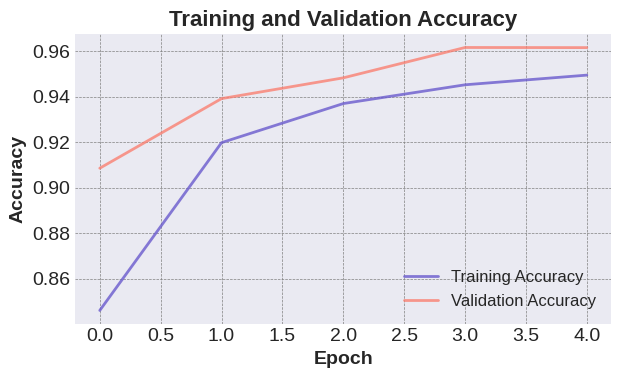

/tmp/ipykernel_29205/1694508447.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')  # Refined look with dark grid


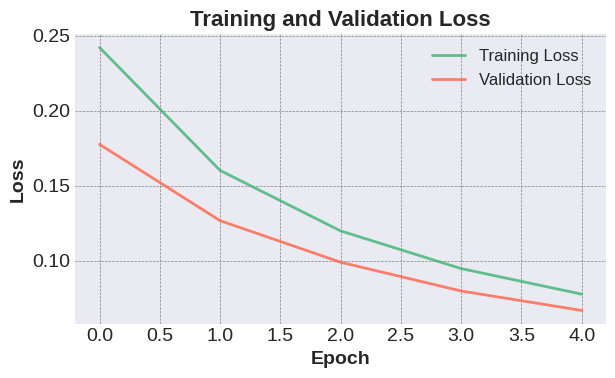

In [17]:
train_data_func("train_data_all.csv")

hacker 0: 1282 , hacker 1: 1491 , hacker 2: 2252
[0 0 2 2 2]
準確度: 0.9976119402985074
混淆矩陣:
(3, 3)


/tmp/ipykernel_29205/1369278411.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


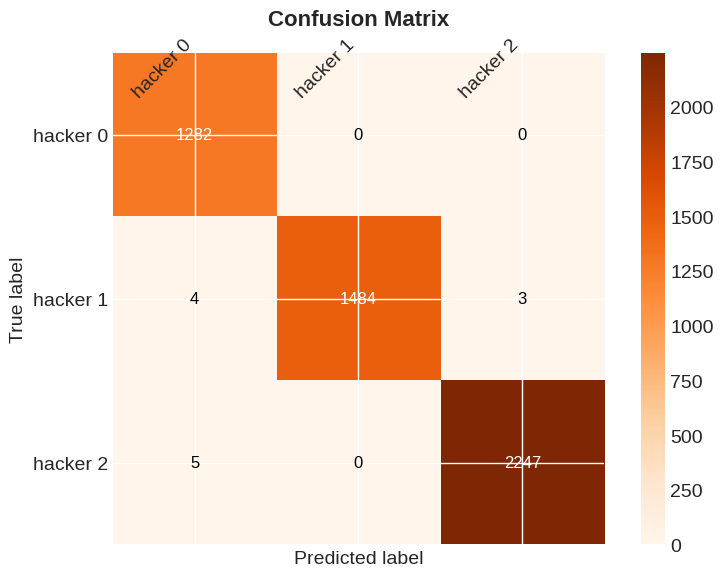

In [18]:
vail_data("test_data_all.csv")

hacker 0: 2454 , hacker 1: 1649 , hacker 2: 2000
[0 0 0 0 0]
準確度: 0.9133213173848926
混淆矩陣:
(3, 3)


/tmp/ipykernel_29205/1369278411.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


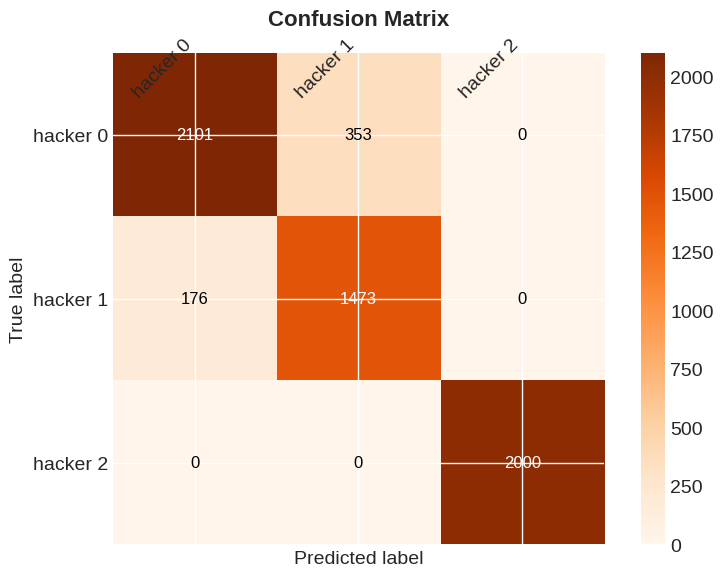

In [19]:
vail_data("test_data_class2.csv")

hacker 0: 8692 , hacker 1: 1491 , hacker 2: 2252
[0 0 2 2 2]
準確度: 0.9990349819059108
混淆矩陣:
(3, 3)


/tmp/ipykernel_29205/1369278411.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


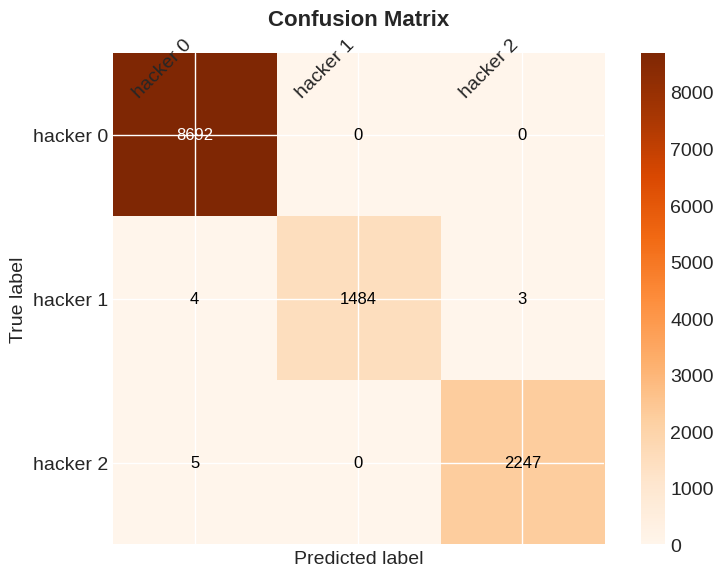

In [20]:
vail_data("test_data_all_tmp.csv")

hacker 0: 2454 , hacker 1: 1649 , hacker 2: 2000
[0 0 0 0 0]
準確度: 0.9133213173848926
混淆矩陣:
(3, 3)


/tmp/ipykernel_29205/1369278411.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


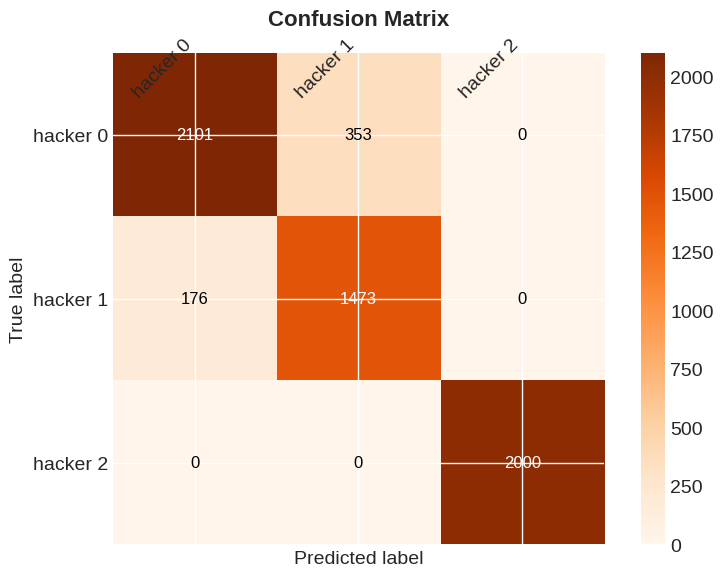

In [21]:
vail_data("test_data_class2.csv")

hacker 0: 1911 , hacker 1: 0 , hacker 2: 0
[0 2 0 0 0]
準確度: 0.7624280481423339
混淆矩陣:
(3, 3)


/tmp/ipykernel_29205/1369278411.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


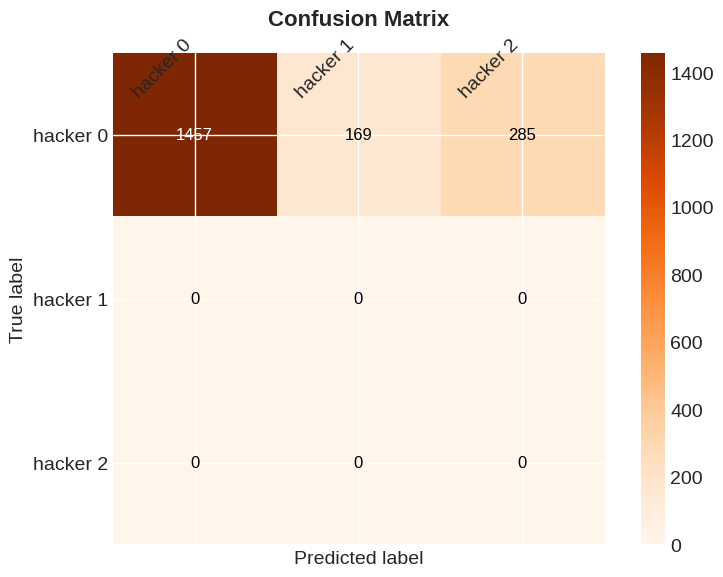

In [22]:
vail_data("Event_20231228_1626_class0_new.csv")

hacker 0: 7549 , hacker 1: 8107 , hacker 2: 5425
[0 0 0 0 0]
準確度: 0.8315070442578625
混淆矩陣:
(3, 3)


/tmp/ipykernel_29205/1369278411.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


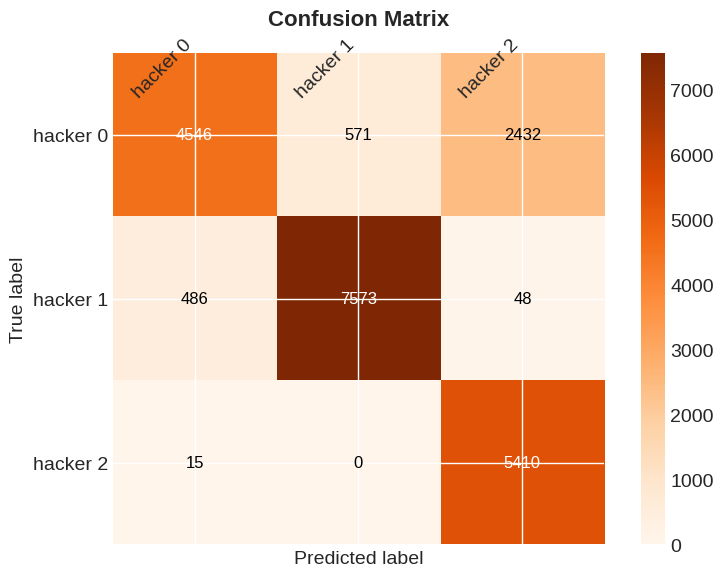

In [23]:
vail_data("train_data.csv")

hacker 0: 20000 , hacker 1: 0 , hacker 2: 0
[2 2 0 0 0]
準確度: 0.22115
混淆矩陣:
(3, 3)


/tmp/ipykernel_29205/1369278411.py:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-muted')


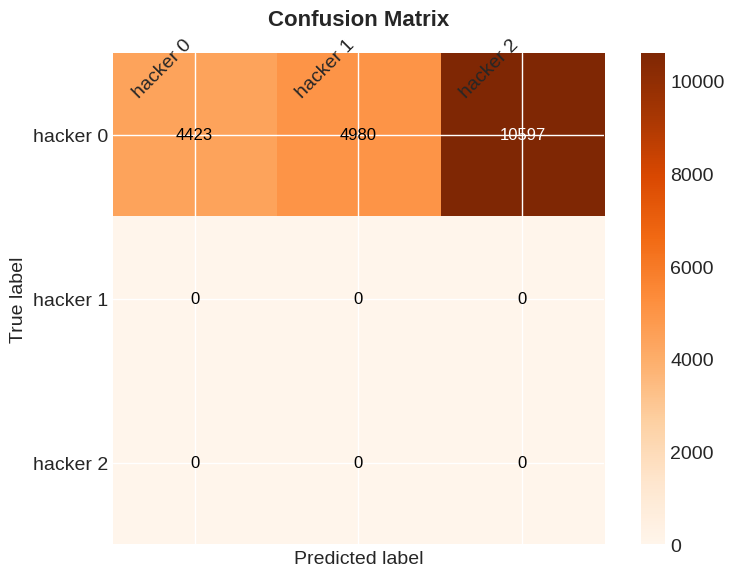

In [24]:
vail_data("test_data_class0_1.csv")